In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            'Train',
            shuffle = True,
            image_size = (IMAGE_SIZE,IMAGE_SIZE),
            batch_size = (BATCH_SIZE)

    )

Found 5550 files belonging to 5 classes.


In [5]:
class_names = dataset.class_names
class_names

['basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'seborrheic keratosis',
 'squamous cell carcinoma']

[0 4 1 0 2 2 0 3 2 3 3 2 3 4 3 4 2 1 0 2 2 2 2 0 2 0 2 2 4 4 0 2]


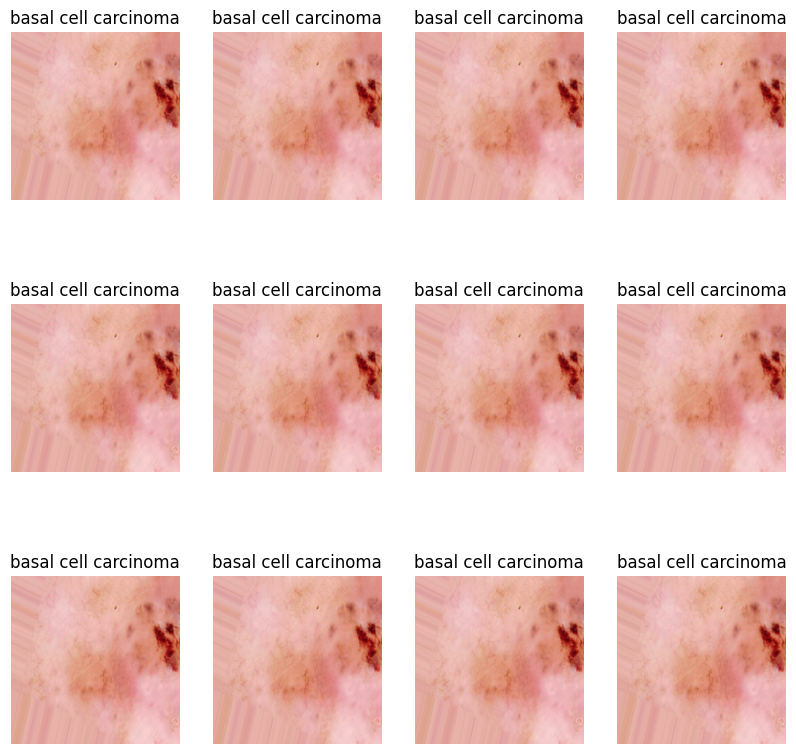

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(label_batch.numpy())
    for i in range (12): 
     ax = plt.subplot(3,4,i+1)
     plt.imshow(image_batch[0].numpy().astype('uint8'))
     plt.axis('off')
     plt.title(class_names[label_batch[0]])

In [7]:
len(dataset)

174

In [8]:
37*32

1184

In [9]:
def dataset_splitting(ds, train_split = 0.8, test_split = 0.1, val_split = 0.1, shuffle = True, shuffle_size = 1000):

  if shuffle == True:
    ds = ds.shuffle(shuffle_size, seed = 12)    
    ds_size = len(ds)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = dataset_splitting(dataset)

In [11]:
len(test_ds)

18

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [14]:
#data_augmentation = tf.keras.Sequential([
 # layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  #layers.experimental.preprocessing.RandomRotation(0.2),
#])


In [15]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model = models.Sequential([
    resize_and_rescale,
   # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.2),
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(5, activation = 'softmax'), #5 is the numbers of classes
    
        ])

model.build(input_shape=input_shape)

In [16]:
model.summary()
#layers.Dropout(rate=0.4),

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (32, 127, 127, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)         

In [17]:
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25


139/139 [==============================] - 289s 2s/step - loss: 1.2172 - accuracy: 0.5616 - val_loss: 2.7036 - val_accuracy: 0.3382
Epoch 2/25
139/139 [==============================] - 212s 2s/step - loss: 0.9601 - accuracy: 0.6317 - val_loss: 1.5287 - val_accuracy: 0.4081
Epoch 3/25
139/139 [==============================] - 197s 1s/step - loss: 0.8339 - accuracy: 0.6749 - val_loss: 2.2992 - val_accuracy: 0.3842
Epoch 4/25
139/139 [==============================] - 198s 1s/step - loss: 0.6762 - accuracy: 0.7403 - val_loss: 1.1645 - val_accuracy: 0.6544
Epoch 5/25
139/139 [==============================] - 196s 1s/step - loss: 0.5355 - accuracy: 0.7959 - val_loss: 2.9394 - val_accuracy: 0.4688
Epoch 6/25
139/139 [==============================] - 196s 1s/step - loss: 0.4286 - accuracy: 0.8368 - val_loss: 1.0685 - val_accuracy: 0.6397
Epoch 7/25
139/139 [==============================] - 200s 1s/step - loss: 0.3162 - accuracy: 0.8811 - val_loss: 0.5618 - val_accuracy: 0.79

In [18]:
#pip install pickle
#import pickle 

#with open('model_pickle','wb') as f:
 #   pickle.dump(model,f)

In [18]:
import pickle 

with open('model_pickle','rb') as f:
  md = pickle.load(f)

In [19]:
md.evaluate(val_ds)



17/17 [==============================] - 39s 558ms/step - loss: 1.5928 - accuracy: 0.7353


[1.5927706956863403, 0.7352941036224365]

1/1 [==============================] - 0s 422ms/step
[1.1270517e-07 2.5719402e-10 9.9997497e-01 2.4940671e-05 2.5454101e-11]


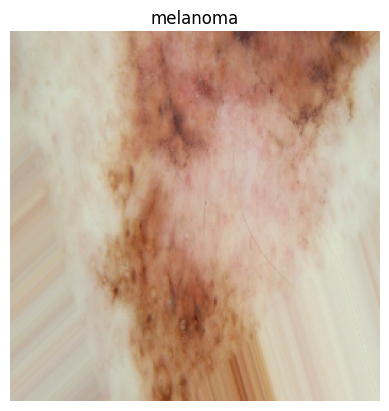

In [41]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.axis('off')
    plt.title(class_names[label_batch[0]])
    prediction = md.predict(image_batch)
    
    print(prediction[0])
    

In [36]:
md.save('my_model.keras')


In [39]:
from tensorflow.keras.models import load_model
loaded_model = load_model('my_model.keras')

In [40]:
loaded_model.evaluate(val_ds)

17/17 [==============================] - 5s 271ms/step - loss: 1.5928 - accuracy: 0.7353


[1.5927708148956299, 0.7352941036224365]